# LSTM for Cyberbullying Detection

Multi-label classification on Jigsaw Toxic Comment dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/DL_cyber_data/train.csv'

Mounted at /content/drive


In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

CUDA available: True
Device: Tesla T4


In [3]:
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
from collections import Counter
import time

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

def build_vocab(texts, max_vocab=10000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in counter.most_common(max_vocab - 2):
        vocab[word] = len(vocab)
    return vocab

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = [self.vocab.get(w, 1) for w in self.texts[idx].split()]
        if len(tokens) < self.max_len:
            tokens += [0] * (self.max_len - len(tokens))
        else:
            tokens = tokens[:self.max_len]
        return torch.LongTensor(tokens), torch.FloatTensor(self.labels[idx])

In [5]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        return self.fc(self.dropout(hidden))

In [6]:
def accuracy_multilabel(preds, labels):
    preds = (torch.sigmoid(preds) > 0.5).float()
    return (preds == labels).float().mean()

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_acc = 0, 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_multilabel(preds, labels).item()
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            preds = model(texts)
            total_loss += criterion(preds, labels).item()
            total_acc += accuracy_multilabel(preds, labels).item()
    return total_loss / len(loader), total_acc / len(loader)

def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            preds = torch.sigmoid(model(texts.to(device))) > 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

In [7]:
df = pd.read_csv(DATA_PATH)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(f"Total: {len(df)}")
print(f"\nLabels:\n{df[label_cols].sum()}")

Total: 159571

Labels:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [8]:
df['num_labels'] = df[label_cols].sum(axis=1)
print("Number of labels per comment:")
print(df['num_labels'].value_counts().sort_index())

Number of labels per comment:
num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64


In [9]:
df['clean_text'] = df['comment_text'].apply(clean_text)

print("Sample comments:")
for i in range(2):
    print(f"\n{i+1}. {df['clean_text'].iloc[i][:100]}...")
    labels = [label_cols[j] for j in range(len(label_cols)) if df[label_cols[j]].iloc[i] == 1]
    print(f"   Labels: {labels if labels else ['clean']}")

Sample comments:

1. explanation why the edits made under my username hardcore metallica fan were reverted they werent va...
   Labels: ['clean']

2. daww he matches this background colour im seemingly stuck with thanks talk january utc...
   Labels: ['clean']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'].values, df[label_cols].values, test_size=0.2, random_state=42
)
vocab = build_vocab(X_train)
print(f"Vocab: {len(vocab)}, Train: {len(X_train)}, Test: {len(X_test)}")

Vocab: 10000, Train: 127656, Test: 31915


In [11]:
train_loader = DataLoader(TextDataset(X_train, y_train, vocab), batch_size=64, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test, vocab), batch_size=64)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(len(vocab), 100, 128, len(label_cols)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
print(f"Device: {device}\nParams: {sum(p.numel() for p in model.parameters())}")

Device: cuda
Params: 1632326


In [13]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []
start = time.time()

for epoch in range(10):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.3f} Acc: {train_acc:.3f} | Test Loss: {test_loss:.3f} Acc: {test_acc:.3f}')

print(f"\nTime: {(time.time()-start)/60:.1f} min")

Epoch 01 | Train Loss: 0.085 Acc: 0.974 | Test Loss: 0.059 Acc: 0.980
Epoch 02 | Train Loss: 0.057 Acc: 0.980 | Test Loss: 0.054 Acc: 0.981
Epoch 03 | Train Loss: 0.051 Acc: 0.982 | Test Loss: 0.051 Acc: 0.982
Epoch 04 | Train Loss: 0.047 Acc: 0.983 | Test Loss: 0.047 Acc: 0.983
Epoch 05 | Train Loss: 0.045 Acc: 0.983 | Test Loss: 0.049 Acc: 0.983
Epoch 06 | Train Loss: 0.042 Acc: 0.984 | Test Loss: 0.046 Acc: 0.983
Epoch 07 | Train Loss: 0.040 Acc: 0.985 | Test Loss: 0.048 Acc: 0.983
Epoch 08 | Train Loss: 0.038 Acc: 0.985 | Test Loss: 0.048 Acc: 0.983
Epoch 09 | Train Loss: 0.037 Acc: 0.986 | Test Loss: 0.049 Acc: 0.983
Epoch 10 | Train Loss: 0.035 Acc: 0.986 | Test Loss: 0.054 Acc: 0.983

Time: 5.8 min


In [14]:
y_pred, y_true = get_predictions(model, test_loader, device)
overall = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
print(f"\nOverall - Precision: {overall[0]:.4f}, Recall: {overall[1]:.4f}, F1: {overall[2]:.4f}")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

print("\nPer-label F1:")
for i, label in enumerate(label_cols):
    f1 = precision_recall_fscore_support(y_true[:, i], y_pred[:, i], average='binary', zero_division=0)[2]
    print(f"{label}: {f1:.4f}")


Overall - Precision: 0.8089, Recall: 0.6942, F1: 0.7454
Accuracy: 0.9215

Per-label F1:
toxic: 0.7857
severe_toxic: 0.4869
obscene: 0.8107
threat: 0.4320
insult: 0.7270
identity_hate: 0.4063


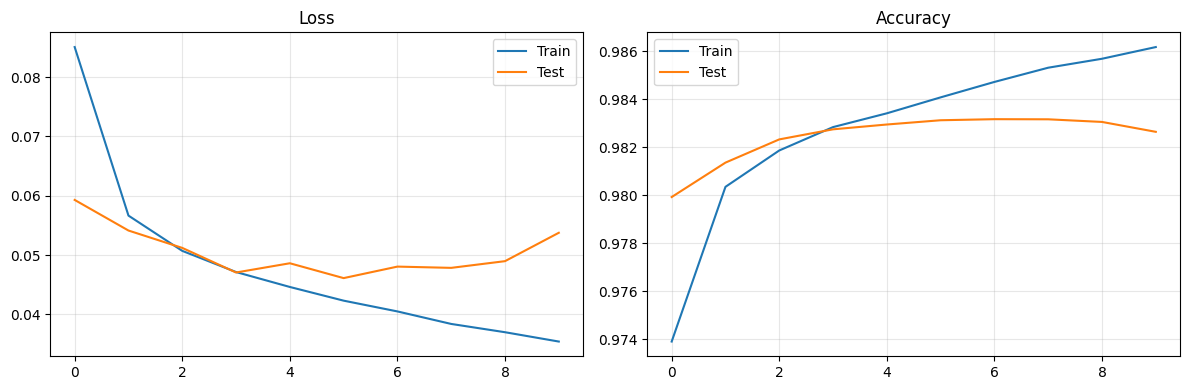

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[1].plot(train_accs, label='Train')
axes[1].plot(test_accs, label='Test')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
torch.save(model.state_dict(), 'lstm_model.pt')